<a href="https://colab.research.google.com/github/MECAI2022/short_text_classification/blob/main/Short_Text_Bert_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sort Text com BERT

In [1]:
!nvidia-smi

Sun Nov  6 22:09:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## O Que é BERT?

BERT (introduzido [neste artigo](https://arxiv.org/abs/1810.04805)) significa  Bidirectional Encoder Representations from Transformers:

- Bidirecional - Para entender o texto que você está analisando, você terá que olhar para trás (nas palavras anteriores) e para frente (nas próximas palavras)
- Transformers - O artigo [Attention Is All You Need](https://arxiv.org/abs/1706.03762) apresentou o modelo Transformer. O Transformer lê sequências inteiras de tokens de uma só vez. Em certo sentido, o modelo é não direcional, enquanto os LSTMs lêem sequencialmente (da esquerda para a direita ou da direita para a esquerda). O mecanismo de atenção permite aprender relações contextuais entre palavras.
- Embeddings de palavras contextualizadas (pré-treinadas) - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduziu uma maneira de codificar palavras com base em seu significado/contexto.

O BERT foi treinado mascarando 15% dos tokens com o objetivo de adivinhá-los. Um objetivo adicional era prever a próxima frase. Vejamos exemplos dessas tarefas:

### Modelagem de linguagem mascarada (LM mascarado)

O objetivo desta tarefa é adivinhar os tokens mascarados. Vamos dar uma olhada em um exemplo, e tentar não torná-lo mais difícil do que tem que ser:

Isso é `[máscara]` ela `[máscara]` -> Isso é o que ela disse

### Previsão da próxima frase (NSP)

Dado um par de duas sentenças, a tarefa é dizer se a segunda segue ou não a primeira (classificação binária). Vamos continuar com o exemplo:

*Input* = `[CLS]` Isso é `[mask]` ela `[mask]`. [SEP] Hahaha, legal! [SEP]

*Rótulo* = *ÉPróximo*

*Input* = `[CLS]` Isso é `[mask]` ela `[mask]`. [SEP] Dwight, seu ignorante `[máscara]`! [SEP]

*Rótulo* = *NãoPróximo*

O corpus de treinamento foi composto por duas entradas: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800 milhões de palavras) e Wikipedia em inglês (2.500 milhões de palavras). Enquanto o Transformer original possui um codificador (para leitura da entrada) e um decodificador (que faz a previsão), o BERT utiliza apenas o decodificador.

BERT é simplesmente vários  pré-treinada de codificadores de transformadores. Quantos codificadores? Temos duas versões - com 12 (BERT base) e 24 (BERT Large).

### Isso é útil na prática?

O artigo BERT foi lançado junto com [o código-fonte](https://github.com/google-research/bert) e modelos pré-treinados.

A melhor parte é que você pode fazer o Transfer Learning (graças às ideias do OpenAI Transformer) com BERT para muitas tarefas de NLP - Classificação, Resposta a Perguntas, Reconhecimento de Entidades, etc. Você pode treinar com pequenas quantidades de dados e obter um ótimo desempenho!

#### Setup & Config

Vamos precisar da [biblioteca Transformers](https://huggingface.co/transformers/) do Hugging Face:

In [2]:
!git clone https://github.com/MECAI2022/short_text_classification.git
import sys
sys.path.append('/content/short_text_classification')
from pre_treatment_product import pre_process_text

Cloning into 'short_text_classification'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 97 (delta 50), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (97/97), done.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
!pip install transformers
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 51.8 MB/s 
     |████████████████████████████████| 163 kB 49.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 7.5 MB/s 


In [12]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup
import torch

import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score,roc_auc_score
from collections import defaultdict
from textwrap import wrap
from sklearn import preprocessing
import itertools

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import nlpaug.augmenter.word as naw


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

In [13]:
filepath = "/content/drive/MyDrive/glove_files/dataset_produtos_V02.xlsx"
filesave = '/content/drive/MyDrive/BERT'

df = pd.read_excel(filepath)
df.head()

pre_treatment = pre_process_text(stopwords_language = 'portuguese',flg_stemm = True , flg_lemm = False)

*   Retirar nome de produtos inválidos
*   Retirar produtos com pouca frequência (<=10)
*   Pré-processar o texto







In [14]:
pre_treatment = pre_process_text(stopwords_language = 'portuguese',flg_stemm = True , flg_lemm = False)

df = df[df['nm_item'].notnull()]
df = df[df['nm_item'].str.lower()!='nao cadastrado'].reset_index(drop=True)

df['nm_item'] = df['nm_item'].apply(lambda x : pre_treatment.transform(x))

df = df.drop_duplicates('nm_item').reset_index(drop=True)

In [15]:
import re
from unicodedata import normalize

def treat_class(word):

        word = word.upper()
          
        #Remove special char

        word = normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII')
        
        #Remove numbers 

        word = re.sub(r'\b\d+\b', '',word)
        #Remove punctuation

        word = re.sub(r'[^\w\s]', '',word)
        #Remove multiple Spaces

        word = re.sub(r'\s+', ' ',word)

        return word

In [16]:
for x in ['segmento','categoria','subcategoria','nm_product']:

  df[x] = df[x].apply(lambda x : treat_class(x))

  count_class = df[x].value_counts()

  print(count_class[count_class<=10].index)

  count_class = count_class[count_class>10].index

  df = df[df[x].isin(count_class)].reset_index(drop=True)

Index([], dtype='object')
Index(['SAUDE ANIMAL', 'SUPLEMENTOS', 'HOSPITALARES E CLINICOS'], dtype='object')
Index(['DUTOS E FIACAO'], dtype='object')
Index(['ESPIGA DE MILHO', 'AMORA', 'PRODUTO SAZONAL', 'GOIABA', 'CACHECOL',
       'GLITER', 'LEITE ESPECIAL', 'RATICIDA', 'ERVILHA SECA', 'ALMEIRAO',
       'COCO SECO', 'MIX DE FOLHAS', 'MIX DE FRIOS', 'NECTARINA',
       'CARNE OVINA', 'RABANETE', 'PINHAO', 'MARACUJA', 'MEXERICA', 'CHICORIA',
       'GERIATRICO', 'PINCA', 'SALSAO', 'OUTRO ACESSORIO PARA CABELOS',
       'MARIA MOLE', 'APONTADOR', 'OUTRO GRAO', 'GENGIBRE',
       'CORANTE ALIMENTAR', 'GUARDACHUVA', 'ESPETINHO CONGELADO', 'REGUA',
       'TINTA ESCOLAR', 'EQUIPAMENTO DE LIMPEZA PISCINA', 'ALHO PORO',
       'MAXIXE', 'FORRAGEM PET', 'BORRACHA', 'ESTOJO', 'OUTRO FERMENTADO',
       'TINTA', 'AIPO', 'SOBREMESA PRONTA RESFRIADA', 'LAPISEIRA',
       'PREPARO PARA SORVETE', 'DOCE DE NATAL', 'CARNE SUINA SAZONAL', 'PASTA',
       'ROMA', 'ALCACHOFRA', 'OUTRO HIGIENE E LIMPEZA

Puxar máximo número de palavras em uma sentença

In [17]:
max_lenght = df["nm_item"].apply(lambda x: len(str(x).split(" "))).max()

Transformar classes com label encoder

In [18]:
for x in ['segmento','categoria','subcategoria','nm_product']:

  le = preprocessing.LabelEncoder()

  df[x+'_enc'] = le.fit_transform(df[x])

  print('categ '+ x + ' ' + str(df[x+'_enc'].max()))


categ segmento 5
categ categoria 63
categ subcategoria 144
categ nm_product 653


## Pré-processamento de dados


Você já deve saber que os modelos de Machine Learning não funcionam com texto bruto. Você precisa converter texto em números (de algum tipo). O BERT requer ainda mais atenção. Aqui estão os requisitos:

- Adicione tokens especiais para separar frases e fazer classificação
- Passe sequências de comprimento constante (introduza o padding)
- Crie um array de 0s (pad token) e 1s (real token) chamado *atention mask*

A biblioteca Transformers fornece uma ampla variedade de modelos de Transformers (incluindo BERT). Funciona com TensorFlow e PyTorch! Ele também inclui tokenizers pré-construídos que fazem o trabalho pesado para nós!

In [6]:
# Pré Treino Bert feito em Português
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

https://huggingface.co/neuralmind/bert-base-portuguese-cased

https://github.com/neuralmind-ai/portuguese-bert

Vamos carregar um pré-treinado [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

### Escolhendo o comprimento da sequência

O BERT trabalha com sequências de comprimento fixo. Usaremos uma estratégia simples para escolher o comprimento máximo. Vamos armazenar o tamanho do token de cada avaliação:

In [19]:
MAX_LEN = max_lenght

Temos todos os blocos de construção necessários para criar um conjunto de dados PyTorch. Vamos fazer isso:

In [20]:
class ProdutosVarejoDataset(Dataset):

  def __init__(self, nm_item, targets, tokenizer, max_len):
    self.nm_item = nm_item
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.nm_item)
  
  def __getitem__(self, item):
    nm_item = str(self.nm_item[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      nm_item,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'nm_item_text': nm_item,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

O tokenizer está fazendo a maior parte do trabalho pesado. Também devolvemos os textos de segmentação, para que seja mais fácil avaliar as previsões do nosso modelo. Vamos dividir os dados:

In [21]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_SEED,stratify = df['nm_product_enc'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED,stratify = df_test['nm_product_enc'])

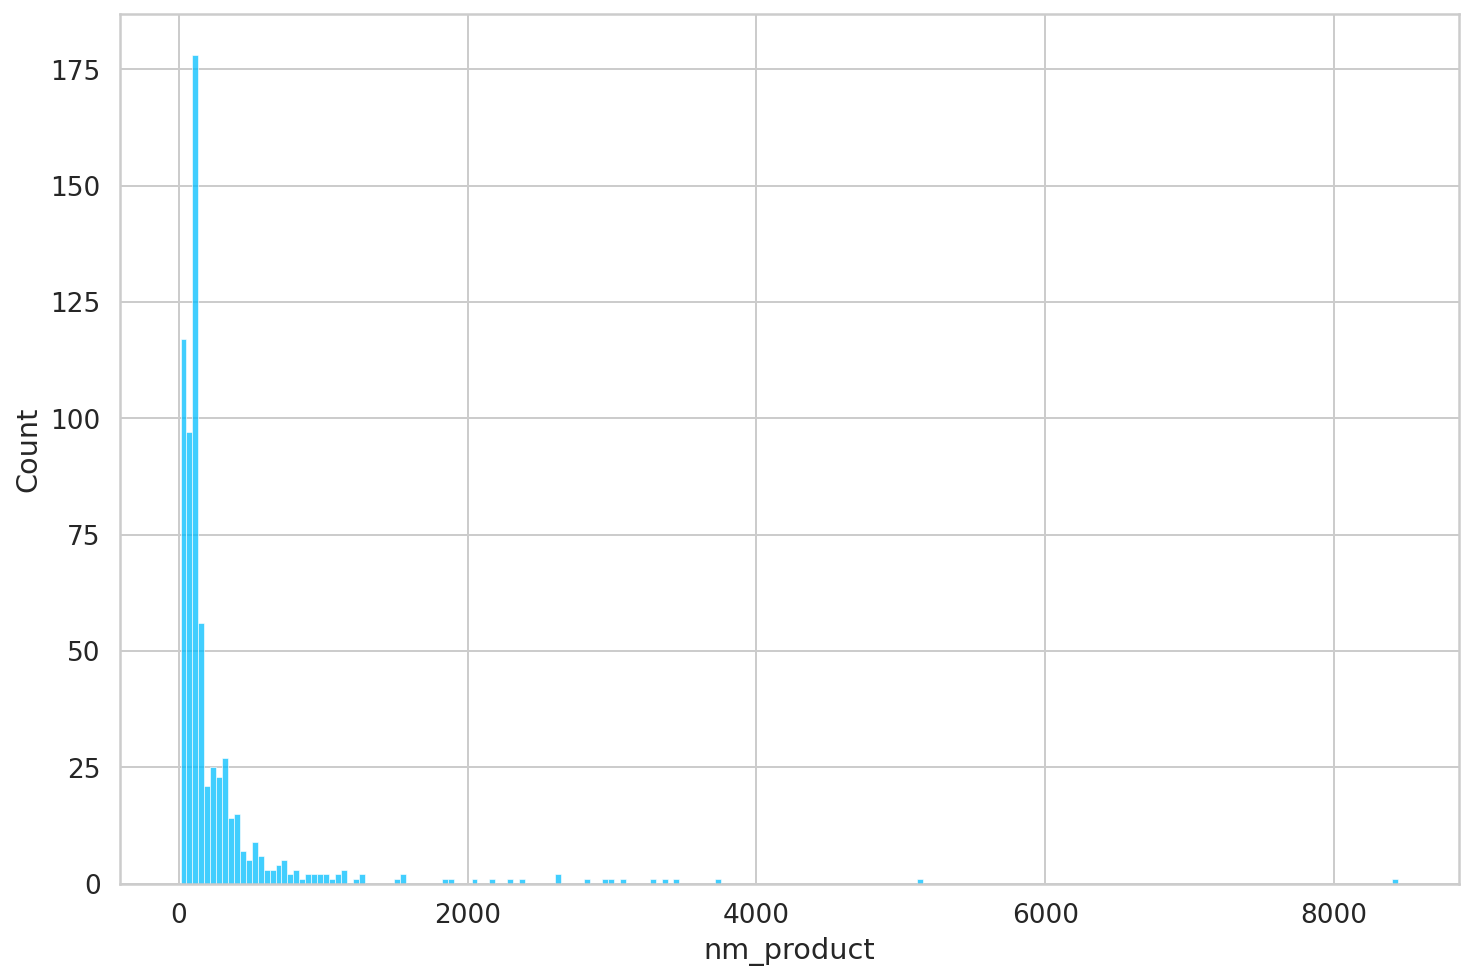

In [88]:
sns.histplot(df['nm_product'].value_counts())

In [89]:
df['nm_product'].value_counts().describe()

count     659.000000
mean      278.666161
std       590.268195
min        10.000000
25%        76.000000
50%       120.000000
75%       255.500000
max      8444.000000
Name: nm_product, dtype: float64

In [22]:
df_train.shape, df_val.shape, df_test.shape

((137693, 9), (22949, 9), (22949, 9))

In [23]:
import nltk
nltk.download('stopwords')

def augment_text(df,class_threshold=50):

    new_text=[]

    class_counts = df['nm_product'].value_counts()

    count_class = class_counts[class_counts <= class_threshold].index

    lst_stopwords = nltk.corpus.stopwords.words('portuguese') 
    aug = naw.SynonymAug(aug_min=1, aug_max=5, lang='por', stopwords=lst_stopwords)

    df_m = df[df[x].isin(count_class)].reset_index(drop=True)
    
    ## data augmentation loop

    final = pd.DataFrame()
    for i in range(0,len(df_m)):
            z=0
            text = df_m.iloc[i]['nm_item']
            augmented_text = aug.augment(text,n = class_threshold - (class_counts[df_m.iloc[i]['nm_product']]) )
            
            augmented_text = list(set(augmented_text))

            base = pd.DataFrame(data = augmented_text,columns = ['nm_item'] )

            base[['segmento','categoria','subcategoria','nm_product',
                  'segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']] = df_m.iloc[i][['segmento','categoria','subcategoria','nm_product',
                                                                                                       'segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']]

            df = pd.concat([df,base],ignore_index=True)

    ## dataframe

    df = df.sample(frac = 1).reset_index(drop=True)

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df_train = augment_text(df_train)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [25]:
df_train.shape, df_val.shape, df_test.shape

((152414, 9), (22949, 9), (22949, 9))

In [26]:
df_train.isnull().sum()

nm_item             0
segmento            0
categoria           0
subcategoria        0
nm_product          0
segmento_enc        0
categoria_enc       0
subcategoria_enc    0
nm_product_enc      0
dtype: int64

Também precisamos criar alguns load dos dados. Aqui está uma função auxiliar para fazer isso:

In [27]:
def create_data_loader(X,y, tokenizer, max_len, batch_size):
  ds = ProdutosVarejoDataset(
    nm_item = X.to_numpy(),
    targets = y.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## Classificação de Produtos com  BERT

In [28]:
class ProductClassifier(nn.Module):

  def __init__(self, number_classes,list_drop_out):

    super(ProductClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p= list_drop_out)

    # O last_hidden_state é uma sequência de estados ocultos da última camada do modelo
    self.out1 = nn.Linear(self.bert.config.hidden_size, number_classes[0])
    self.out2 = nn.Linear(self.bert.config.hidden_size, number_classes[1])
    self.out3 = nn.Linear(self.bert.config.hidden_size, number_classes[2])
    self.out4 = nn.Linear(self.bert.config.hidden_size, number_classes[3])
  
  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)

    return [self.out1(output),self.out2(output),self.out3(output),self.out4(output)]

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [29]:
class FocalLoss(nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2.0, weight=None, reduction: str = 'sum') -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction


    def forward(self, inp: torch.Tensor, targ: torch.Tensor):
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss


In [30]:
def train_epoch(
                model, 
                data_loader, 
                loss_fn, 
                optimizer, 
                device, 
                scheduler, 
                epoch
              ):

  model = model.train()

  losses = []
  correct_predictions = 0

#   final_preds1 = []
#   final_preds2 = []
#   final_preds3 = []
#   final_preds4 = []

#   final_preds = [[],[],[],[]]


  targets_total = []

  with tqdm(data_loader, unit="batch") as tepoch:

    for i,d in enumerate(tepoch):
      
      tepoch.set_description(f"Epoch {epoch}")

      input_ids_ = d["input_ids"].to(device)
      attention_mask_ = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      optimizer.zero_grad()

      outputs = model(
        input_ids=input_ids_,
        attention_mask=attention_mask_
      )

      loss1 = loss_fn[0](outputs[0], targets[:,0])
      loss2 = loss_fn[1](outputs[1], targets[:,1])
      loss3 = loss_fn[2](outputs[2], targets[:,2])
      loss4 = loss_fn[3](outputs[3], targets[:,3])

      loss = loss1 + loss2 + loss3 + loss4

      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()

    #   probs = list(map(lambda x : F.softmax(x, dim=1),outputs))
      
    #   final_preds = list(map(lambda x,y: x.extend(y),final_preds,probs))

    #   final_preds1.extend(probs[0])
    #   final_preds2.extend(probs[1])
    #   final_preds3.extend(probs[2])
    #   final_preds4.extend(probs[3])
    #   targets_total.extend(targets)

      tepoch.set_postfix(loss=loss.item(),                     
                         )
  return  np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device):

  model = model.eval()

  losses = []

  final_preds1 = []
  final_preds2 = []
  final_preds3 = []
  final_preds4 = []

  targets_total = []


#   final_preds = [[],[],[],[]]

  i = 0 
  with torch.no_grad():

    for d in data_loader:

      input_ids_ = d["input_ids"].to(device)
      attention_mask_ = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      optimizer.zero_grad()

      outputs = model(
        input_ids=input_ids_,
        attention_mask=attention_mask_
      )

      loss1 = loss_fn[0](outputs[0], targets[:,0])
      loss2 = loss_fn[1](outputs[1], targets[:,1])
      loss3 = loss_fn[2](outputs[2], targets[:,2])
      loss4 = loss_fn[3](outputs[3], targets[:,3])

      loss = loss1 + loss2 + loss3 + loss4

      losses.append(loss.item())

      probs = list(map(lambda x : F.softmax(x, dim=1),outputs))
      
    #   final_preds = list(map(lambda x,y: x.extend(y),final_preds,probs))

      final_preds1.extend(probs[0])
      final_preds2.extend(probs[1])
      final_preds3.extend(probs[2])
      final_preds4.extend(probs[3])
      targets_total.extend(targets)


  final_preds1 = torch.stack(final_preds1).cpu()
  final_preds2 = torch.stack(final_preds2).cpu()
  final_preds3 = torch.stack(final_preds3).cpu()
  final_preds4 = torch.stack(final_preds4).cpu()

#   final_preds = list(map(lambda x: torch.stack(x).cpu(),final_preds))

  final_preds = [final_preds1,final_preds2,final_preds3,final_preds4]

  targets_total = torch.stack(targets_total).cpu()

  metrics = {}

  for i in range(4):

      # metrics.update({'AUC_'+str(i):roc_auc_score(targets_total[:,i].flatten(),final_preds[i].detach(),average='macro',multi_class='ovo')})

      _, best_values =  torch.max(final_preds[i],dim=1)

      metrics.update({'F1_SCORE_'+str(i):f1_score(targets_total[:,i].flatten(), best_values.detach(), average='macro')})

  return metrics

In [ ]:
%%time

model_dict={
            'paralelo':{"batch_size":[32],
                           "lr_rate":[5e-5],
                           "drop_out":[0.2,0.3,0.5],
                           "gamma1":[2],
                            "gamma2":[2],
                            "gamma3":[2],
                            "gamma4":[2]
                           
                           },
                            }

EPOCHS = 20
EARLY_STOP = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


final_results = pd.read_csv(os.path.join(filesave,"BERT_PARAMETERS_v4.csv"),sep=';',decimal=',',encoding='utf-8')

# final_results = pd.DataFrame()

for modelo in model_dict.keys():
    
    for p in itertools.product(*model_dict[modelo].values()):
        z=0
        parameters=dict(zip(model_dict[modelo].keys(),p))

        if final_results.empty == False:

            check_results = final_results[final_results['Model']==modelo].reset_index(drop=True)

            if check_results.empty == False:   

                if str(parameters) in check_results['parameters'].to_list() :
                    
                    print('rodou')
                    continue

        history = defaultdict(list)
        best_accuracy = {'AUC':0.0,
                         'F1_SCORE':0.0}

        best_accuracy_val = 0 

        count = 0
        class_size = [df['segmento_enc'].nunique(),df['categoria_enc'].nunique(),df['subcategoria_enc'].nunique(),df['nm_product_enc'].nunique()]

        BATCH_SIZE = parameters['batch_size']

        train_data_loader = create_data_loader(df_train['nm_item'],df_train[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        val_data_loader = create_data_loader(df_val['nm_item'],df_val[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        test_data_loader = create_data_loader(df_test['nm_item'],df_test[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        

        model = ProductClassifier(class_size,parameters['drop_out']).to(device)

        optimizer = AdamW(model.parameters(), lr= parameters['lr_rate'], correct_bias=False)
        total_steps = len(train_data_loader) * EPOCHS

        scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer,
        num_warmup_steps= int(total_steps*0.05),
        num_training_steps=total_steps,
        num_cycles = int((total_steps/EPOCHS)/2)

        )

        loss_fn = [FocalLoss(gamma = parameters['gamma1']).to(device),FocalLoss(gamma = parameters['gamma2']).to(device),FocalLoss(gamma = parameters['gamma3']).to(device),FocalLoss(gamma = parameters['gamma4']).to(device)]

        model = model.to(device)

        for epoch in range(EPOCHS):

            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_loss = train_epoch(
                model,
                train_data_loader, 
                loss_fn,
                optimizer, 
                device,
                scheduler,
                epoch = epoch
            )

            print(f'Train loss {train_loss}')

            metrics_val = eval_model(
                model,
                val_data_loader,
                loss_fn, 
                device,
            )

        
            F1_mean = (metrics_val['F1_SCORE_0']+metrics_val['F1_SCORE_1']+metrics_val['F1_SCORE_2']+metrics_val['F1_SCORE_3'])/4

            print('f1-score {f1_score}'.format(f1_score =F1_mean))

            if round(F1_mean,5) > round(best_accuracy_val,5):

                torch.save(model.state_dict(), 'best_model_state.bin')
                best_accuracy_val = F1_mean
                best_accuracy = metrics_val

                count = 0

            else:

                count += 1

                if count >= EARLY_STOP:

                    break

        metrics  =  eval_model(
                              model,
                              test_data_loader,
                              loss_fn, 
                              device,
                                    )

        results=pd.DataFrame([{'Model':modelo,
                    'parameters':parameters,

                    # 'AUC_VAL_SEGMENTO':best_accuracy['AUC_0'],
                    # 'AUC_VAL_CATEGORIA':best_accuracy['AUC_1'],
                    # 'AUC_VAL_SUBCATEGORIA':best_accuracy['AUC_2'],
                    # 'AUC_VAL_PRODUTO':best_accuracy['AUC_3'],

                    'F1_SCORE_VAL_SEGMENTO':best_accuracy['F1_SCORE_0'],
                    'F1_SCORE_VAL_CATEGORIA':best_accuracy['F1_SCORE_1'],
                    'F1_SCORE_VAL_SUBCATEGORIA':best_accuracy['F1_SCORE_2'],
                    'F1_SCORE_VAL_PRODUTO':best_accuracy['F1_SCORE_3'],

                    # 'AUC_TEST_SEGMENTO':metrics['AUC_0'],
                    # 'AUC_TEST_CATEGORIA':metrics['AUC_1'],
                    # 'AUC_TEST_SUBCATEGORIA':metrics['AUC_2'],
                    # 'AUC_TEST_PRODUTO':metrics['AUC_3'],

                    'F1_SCORE_TEST_SEGMENTO':metrics['F1_SCORE_0'],
                    'F1_SCORE_TEST_CATEGORIA':metrics['F1_SCORE_1'],
                    'F1_SCORE_TEST_SUBCATEGORIA':metrics['F1_SCORE_2'],
                    'F1_SCORE_TEST_PRODUTO':metrics['F1_SCORE_3'],

                    }])

        final_results=final_results.append(results,ignore_index=True)

        final_results.to_csv(os.path.join(filesave,"BERT_PARAMETERS_v4.csv"),sep=';',decimal=',',encoding='utf-8',
                    index=False)

### Evaluation

Então, quão bom é o nosso modelo na previsão de Segmento? Vamos começar calculando a precisão nos dados de teste:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

NameError: name 'test_data_loader' is not defined

Vamos definir uma função auxiliar para obter as previsões do nosso modelo:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Vamos dar uma olhada no relatório de classificação



In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

                       precision    recall  f1-score   support

    1-BENS DE CONSUMO       1.00      1.00      1.00      7639
         5-HEALTHCARE       0.97      0.88      0.92        72
  2-CASA E CONSTRUCAO       0.91      0.93      0.92       102
4-FASHION E ESPORTIVO       0.92      0.95      0.93        59
       3-ELETROMOVEIS       0.95      0.91      0.93        23
       6-PETROQUIMICA       0.80      0.73      0.76        11

             accuracy                           0.99      7906
            macro avg       0.93      0.90      0.91      7906
         weighted avg       0.99      0.99      0.99      7906




Temos muitos poucos exmplos de Petroquimica o leva o modelo a errar bastante nesse segmento

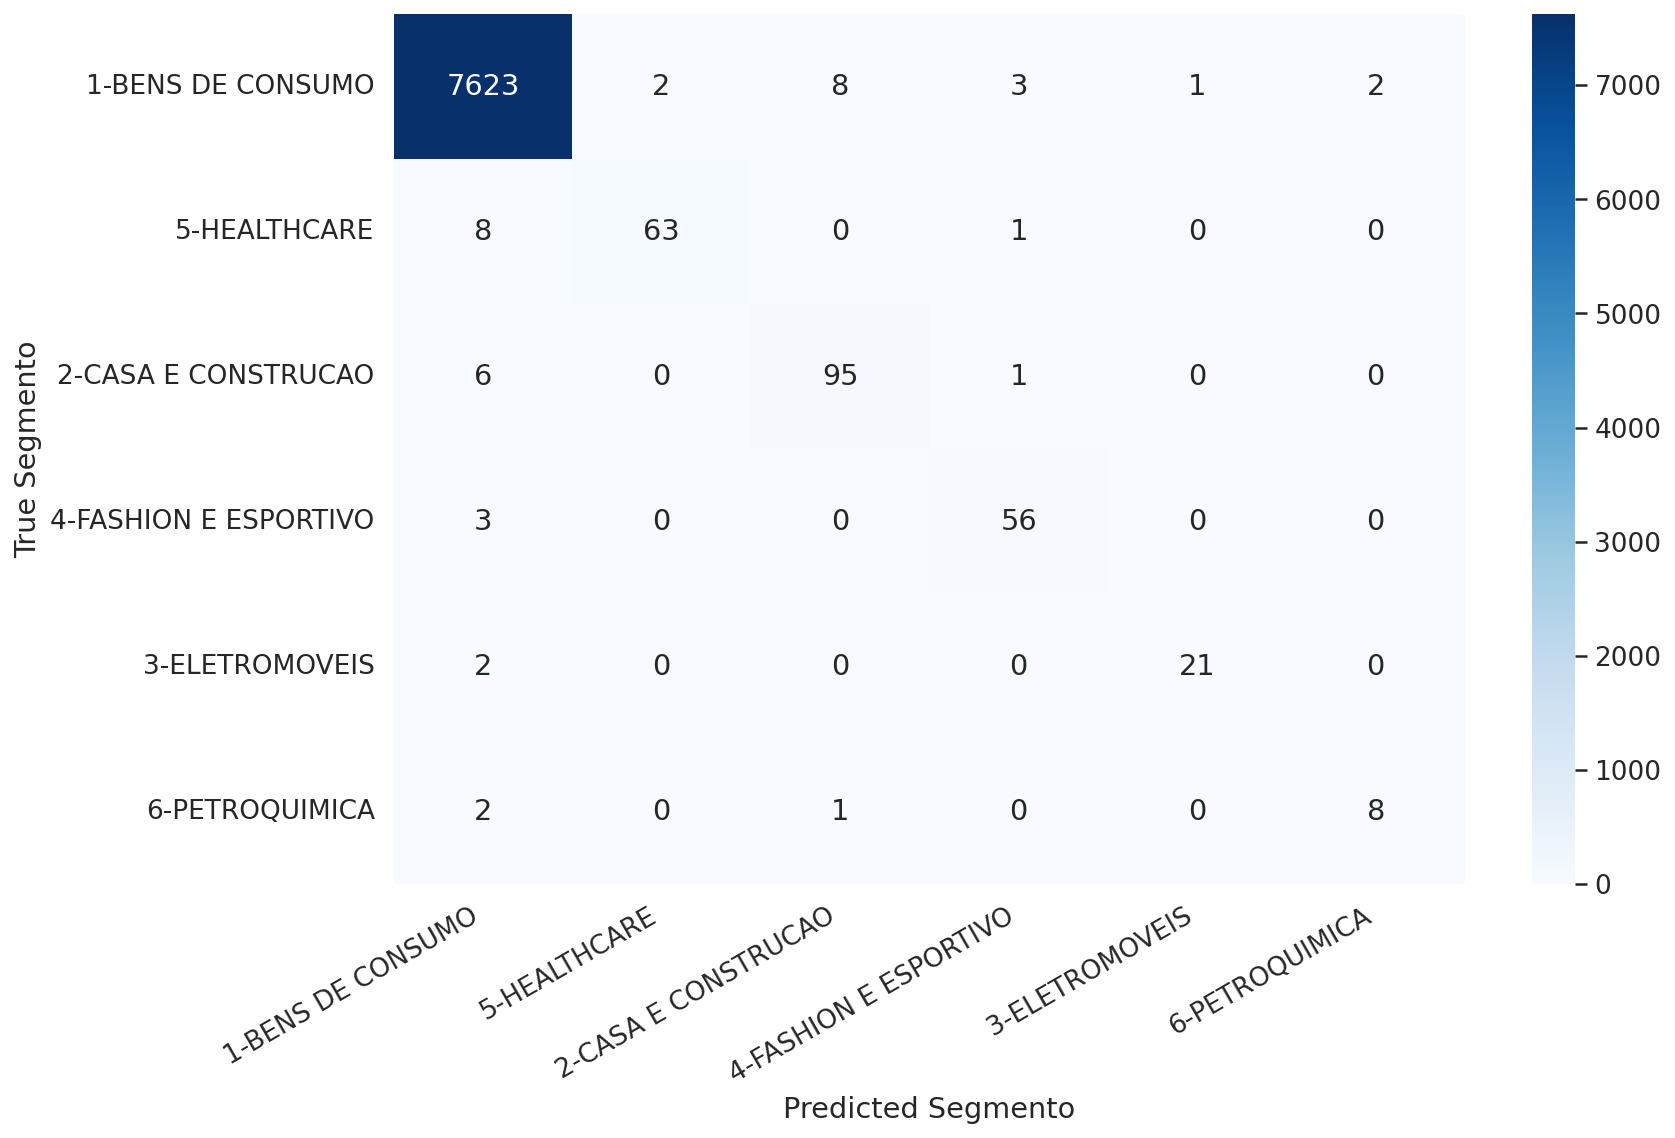

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Segmento')
  plt.xlabel('Predicted Segmento');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

Isso confirma que nosso modelo está tendo dificuldade em classificar segmento de Petroquimica.

## Utilizando o Modelo

Vamos usar nosso modelo para prever o segmento de algum texto novo:

In [ ]:
import json

# ler o json
with open('product.json', 'r') as myfile:
    data=myfile.read()
produtos = json.loads(data)

label_segmento = np.array(produtos['segmento'])
label_categoria = np.array(produtos['categoria'])
label_subcategoria = np.array(produtos['subcategoria'])
label_produto = np.array(produtos['produto'])

In [ ]:
class ProductClassifier(nn.Module):

  def __init__(self, n_classes):
    super(ProductClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

# Pré Treino Bert feito em Português
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 15

In [ ]:
# Carregando os Modelos
segmento_model = ProductClassifier(len(label_segmento))
segmento_model.load_state_dict(torch.load('pesos/bert_segmento.bin'))
segmento_model = segmento_model.to(device)
categoria_model = ProductClassifier(len(label_categoria))
categoria_model.load_state_dict(torch.load('pesos/bert_categoria.bin'))
categoria_model = categoria_model.to(device)
subcategoria_model = ProductClassifier(len(label_subcategoria))
subcategoria_model.load_state_dict(torch.load('pesos/bert_subcategoria.bin'))
subcategoria_model = subcategoria_model.to(device)
produto_model = ProductClassifier(len(label_produto))
produto_model.load_state_dict(torch.load('pesos/bert_produto.bin'))
produto_model = produto_model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predicti

In [ ]:
def prediction(text, model, topk):
    text = text.upper()
    encoded_review = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.topk(output, topk)
    index = prediction.cpu().data.numpy().flatten()

    return index

Temos que usar o tokenizer para codificar o texto:



In [ ]:
# Fazendo previsões com o modelo
text = "tempero"
segmento_pred = prediction(text, segmento_model, 1)
print(f'Segmento: {label_segmento[segmento_pred]}')
categoria_pred = prediction(text, categoria_model, 3)
print(f'Categoria: {label_categoria[categoria_pred]}')
subcategoria_pred = prediction(text, subcategoria_model, 5)
print(f'Subcategoria: {label_subcategoria[subcategoria_pred]}')
produto_pred = prediction(text, produto_model, 5)
print(f'Produto: {label_produto[produto_pred]}')

Segmento: ['1-BENS DE CONSUMO']
Categoria: ['6-MERCEARIA' '5-HORTIFRUTI (FLV)' '13-DIVERSOS BAZAR E DEPARTAMENTOS']
Subcategoria: ['15-CONDIMENTOS' '11-LEGUMES' '44-DIVERSOS BAZAR E DEPARTAMENTOS'
 '66-VEGETAL HIGIENIZADO E PROCESSADO' '166-MODA INVERNO']
Produto: ['TEMPERO PRONTO' 'CALDO INDUSTRIALIZADO' 'BALA' 'AMENDOIM'
 'VEGETAL HIGIENIZADO E PROCESSADO']
